In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def image_read1(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read the image.")
        return
    return  img
def image_read(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read the image.")
        return

    h, w, _ = img.shape
    crop_x = int(w * 0.15)
    crop_y = int(h * 0.15)

    cropped_img = img[crop_y:h - crop_y, crop_x:w - crop_x]
    return cropped_img

def image_read_grayscale(image_path):
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not read the image.")
        return
    return  img


def image_read_hsv(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: Could not read the image.")
        return None

    # Convert to HSV
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    h, w, _ = img_hsv.shape
    crop_x = int(w * 0.21)
    crop_y = int(h * 0.21)
    cropped_hsv = img_hsv[crop_y:h - crop_y, crop_x:w - crop_x]

    return cropped_hsv


def show_image(matrix,x ,windowName):
    padded_matrix = np.array(matrix, dtype=np.uint8) *x
    print('padded matrix: ', padded_matrix.shape)

    cv2.imshow(windowName, padded_matrix)
    cv2.waitKey(0)
    cv2.destroyWindow(windowName)


def padded_image(img,padd):
    height, width = img.shape[:2]
    if len(img.shape) == 2:
        padded_matrix = np.ones((height + 2 * padd, width + 2 * padd), dtype=np.uint8) * 0
        padded_matrix[padd:padd + height, padd:padd + width] = img
    else:
        channels = img.shape[2]
        padded_matrix = np.ones((height + 2*padd, width + 2*padd,channels), dtype=np.uint8)*0
        padded_matrix[padd:padd+height, padd:padd+width,:] = img
    return padded_matrix


def cal_histogram(img):
    rows,cols=img.shape[:2]
    arr=np.zeros(256,dtype=int)
    arr1=np.zeros(256,dtype=int)
    arr2=np.zeros(256,dtype=int)
    for i in range(rows):
        for j in range(cols):
            b, g, r=img[i][j]
            arr[b]+=1
            arr1[g] += 1
            arr2[r] += 1

    return arr,arr1,arr2

def plot_graph(data, title, xlabel, ylabel, color):
    plt.figure()
    plt.plot(data, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def find_root(eq_list, key):
    if key not in eq_list:
        eq_list[key] = key
        return key
    while eq_list[key] != key:
        eq_list[key] = eq_list[eq_list[key]]  # Path compression
        key = eq_list[key]
    return key

def connectivit_8(image,upp_limit,low_limit=0):
    height, width = image.shape[:2]
    connect_8 = np.zeros((height,width), dtype=np.uint16)
    eq_list = {}
    label = 1

    for i in range(1, height):
        for j in range(1, width):
            if image[i, j]>low_limit and image[i,j] <=upp_limit:  # Foreground pixel
                neighbors = []
                if image[i, j - 1]>low_limit and  image[i, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i, j - 1])
                if image[i - 1, j]> low_limit and image[i - 1, j]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j])
                if image[i - 1, j - 1] > low_limit  and image[i - 1, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j -1])
                if (j+1)<width and (image[i - 1, j + 1]>low_limit and image[i - 1, j + 1] <=upp_limit):
                    neighbors.append(connect_8[i - 1, j + 1])

                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[find_root(eq_list, neighbor)] = find_root(eq_list, min_label)

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = find_root(eq_list, connect_8[i, j])
    """
    unique_labels = set(find_root(eq_list, lbl) for lbl in eq_list.values())
    print("Number of labels:", len(unique_labels))
    print("Equivalence list:", eq_list)
    print(f"Unique Vals: {unique_labels}")
    """
    return connect_8, eq_list


def gauss_filter(size, sigma=1):
    midpoint = size // 2
    val = 0
    frame = np.zeros((size, size), dtype=np.float32)
    for i in range(size):
        for j in range(size):
            x = i - midpoint
            y = j - midpoint
            temp = 1 / (2 * np.pi * sigma ** 2)
            frame[i][j] = (temp * np.exp(-((x ** 2 + y ** 2) / (2 * (sigma ** 2)))))
            val += frame[i][j]
    return frame / val

def apply_gauss(image, size=5, sigma=1):
    frame = gauss_filter(size, sigma)
    rows, cols = image.shape
    output_img = np.zeros((rows, cols), dtype=np.uint8)
    padd_size = size // 2
    padd_img = padded_image(image, padd_size)
    pix_min = np.min(image)
    pix_max = np.max(image)
    for i in range(padd_size, rows + padd_size):
        for j in range(padd_size, cols + padd_size):
            patch= padd_img[i - padd_size:i + padd_size + 1, j - padd_size:j + padd_size + 1]
            new_value=np.sum(np.multiply(patch,frame))
            if pix_max != pix_min:
                normalized_value = int(255 * (new_value - pix_min) / (pix_max - pix_min))
                output_img[i - padd_size, j - padd_size] = normalized_value
            else:
                output_img[i - padd_size, j - padd_size] = int(new_value)
    return output_img


def thresholding(mag_matrix,max_val):
    upperlimit=0.7*max_val
    lowerlimit=0.2*max_val
    rows, cols = mag_matrix.shape[:2]
    matrix = np.zeros((rows,cols), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, cols):
            if mag_matrix[i][j] >= upperlimit:
                matrix[i][j] = 1
            elif mag_matrix[i][j] <= lowerlimit:
                matrix[i][j] = 0
            else:
                matrix[i][j]=mag_matrix[i][j]
    return matrix

def color_img(img,x):
    rows,cols=img.shape
    matrix = np.array(img, dtype=np.uint8)
    for i in range(0,rows):
        for j in range (0,cols):
            if img[i][j]>0 :
                matrix[i][j]=x
            else:
                matrix[i][j]=0
    return matrix

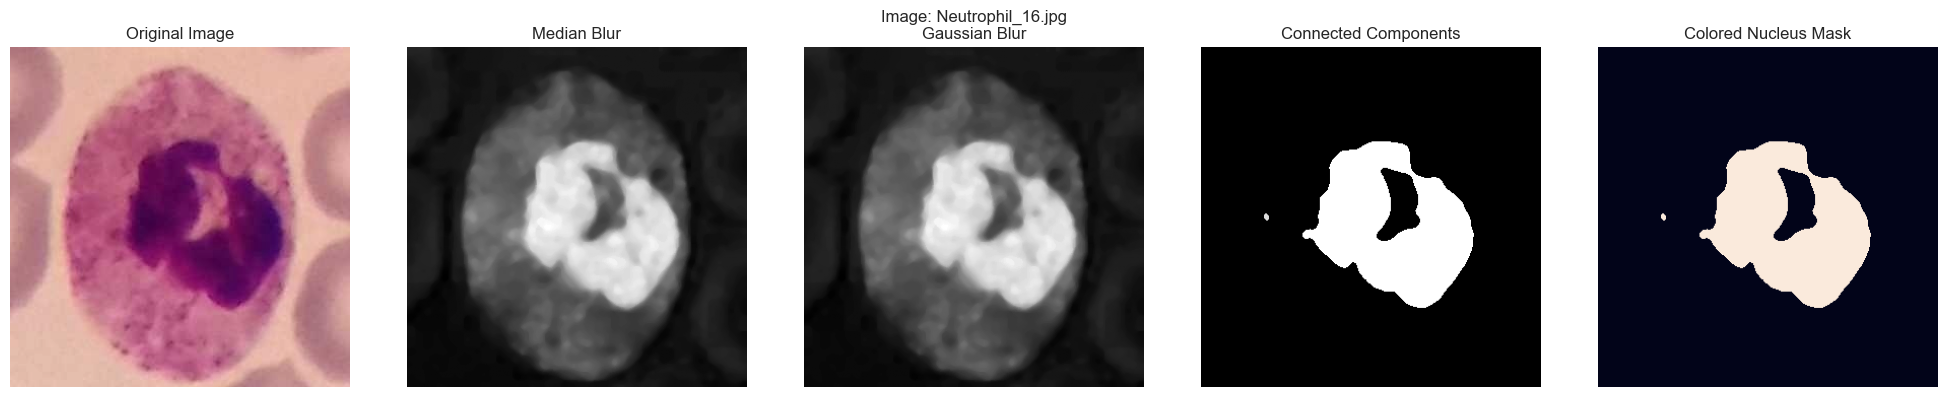

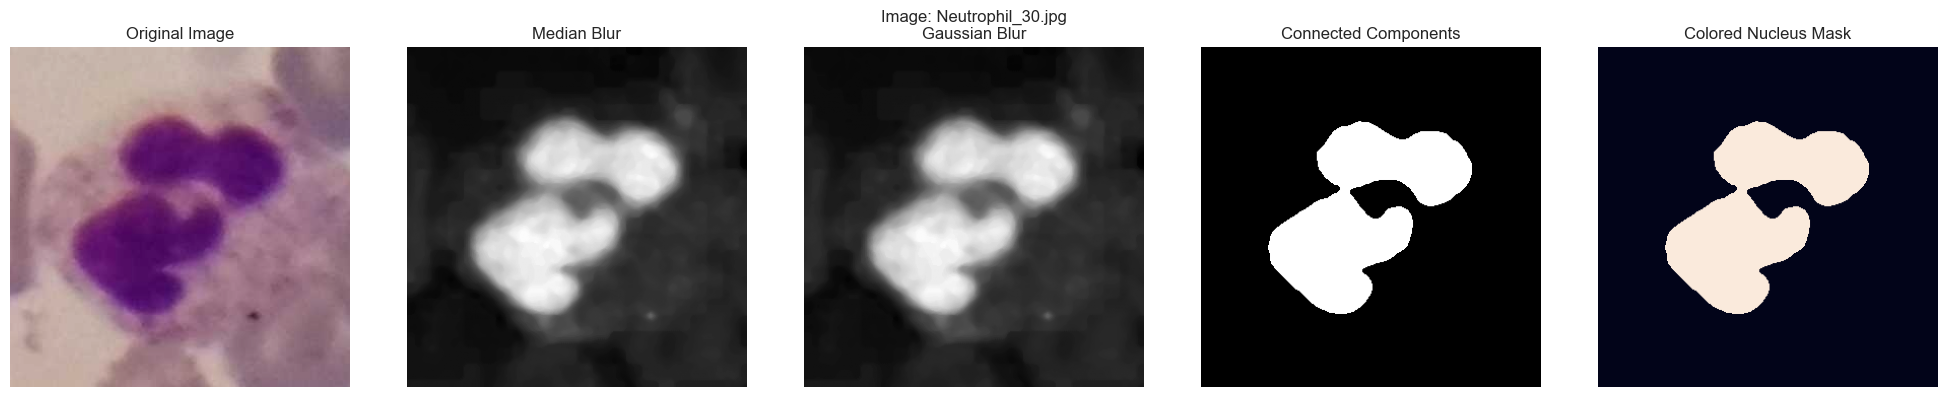

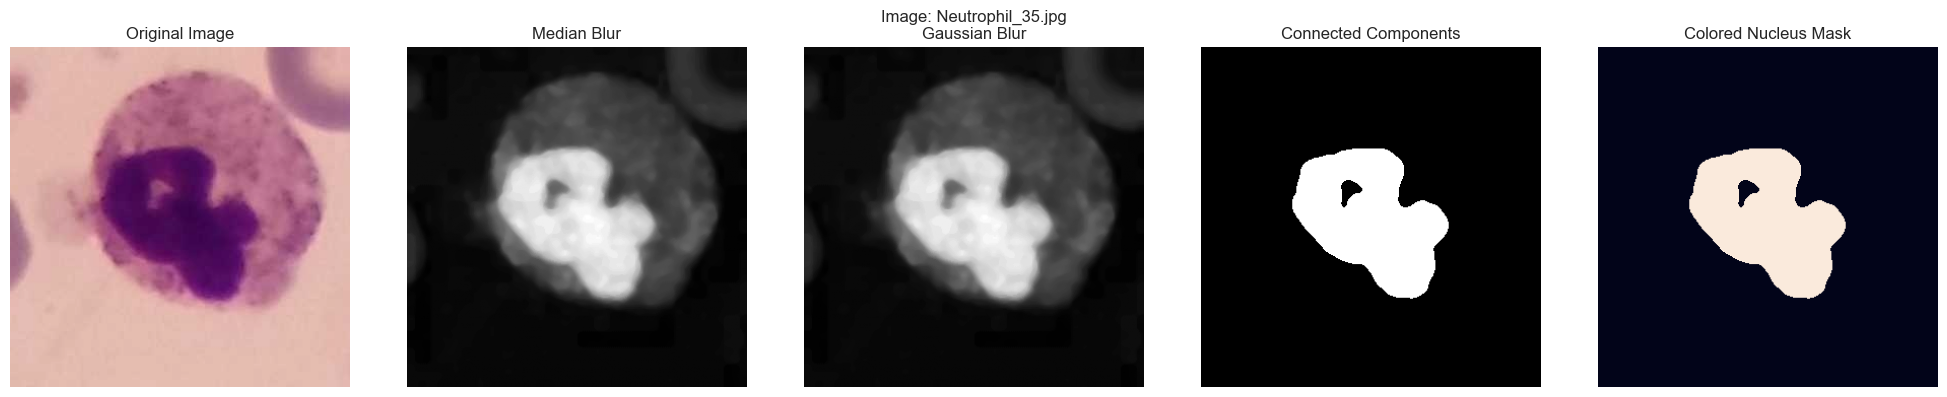

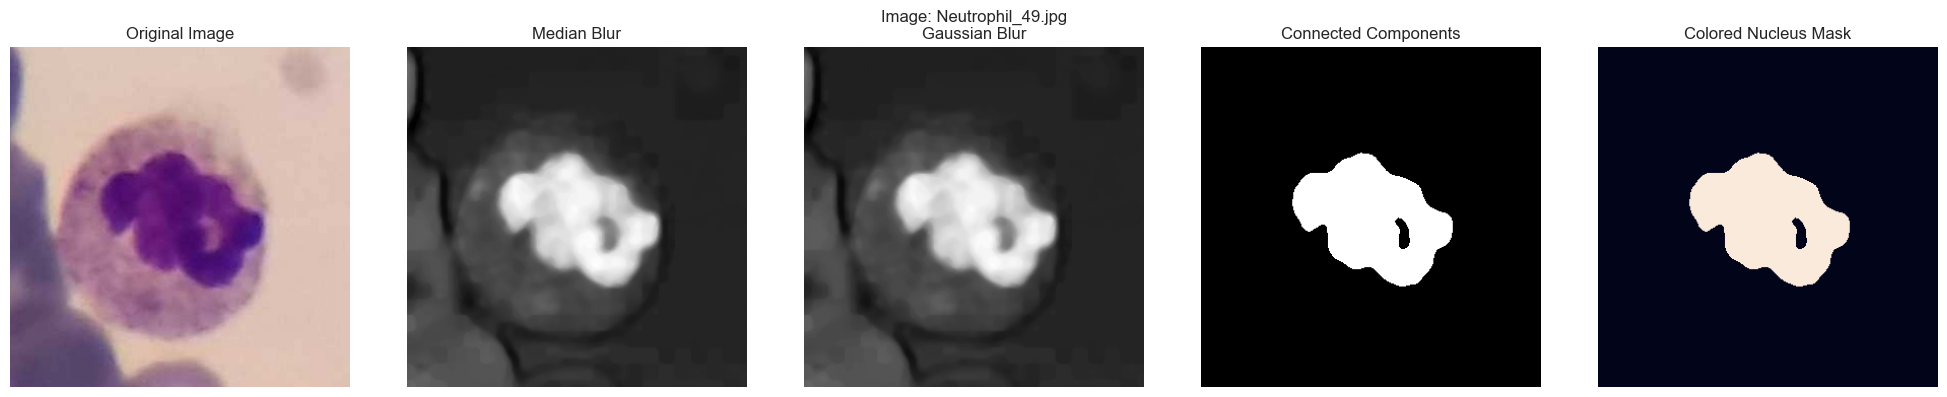

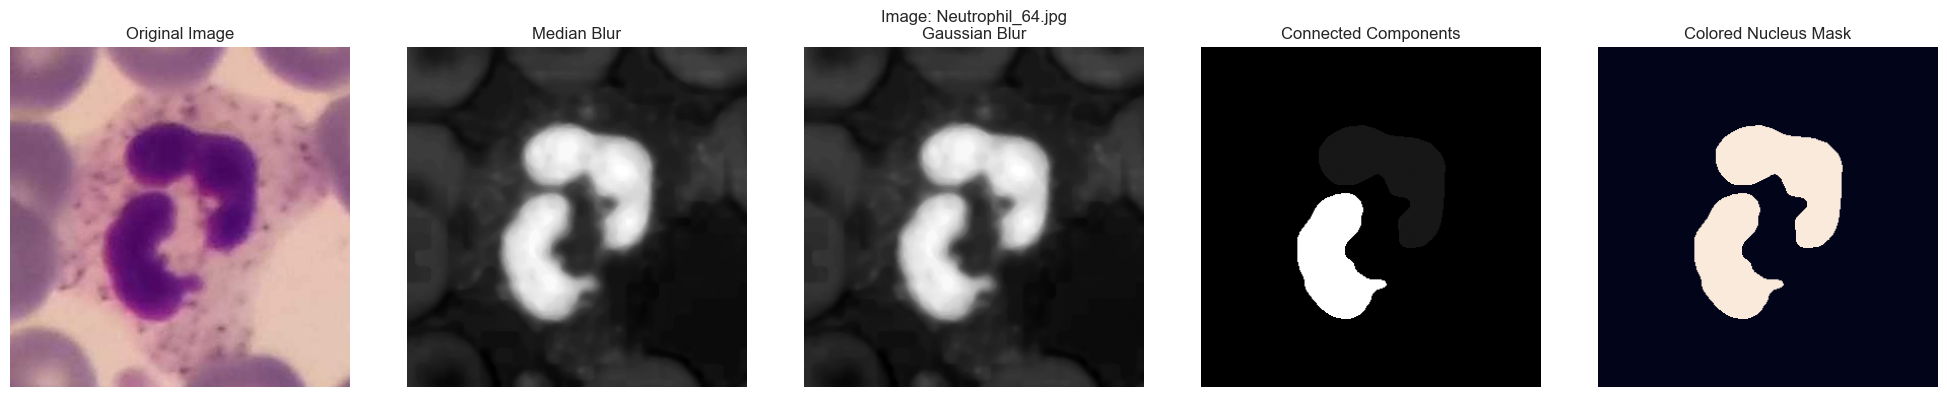

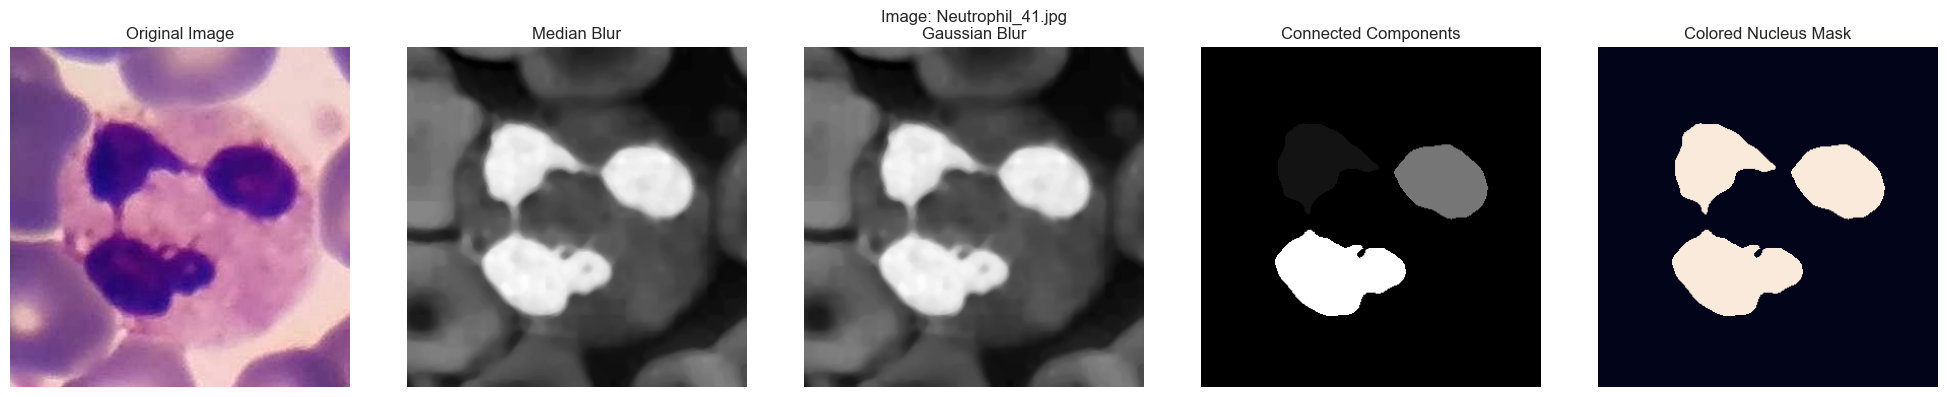

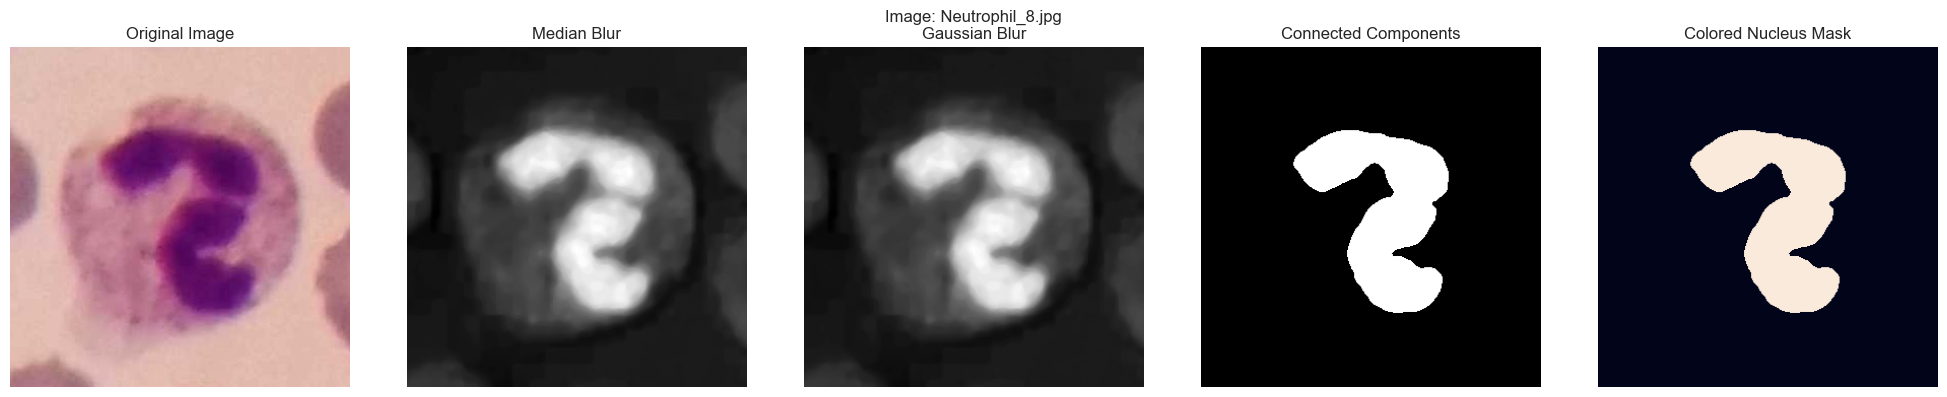

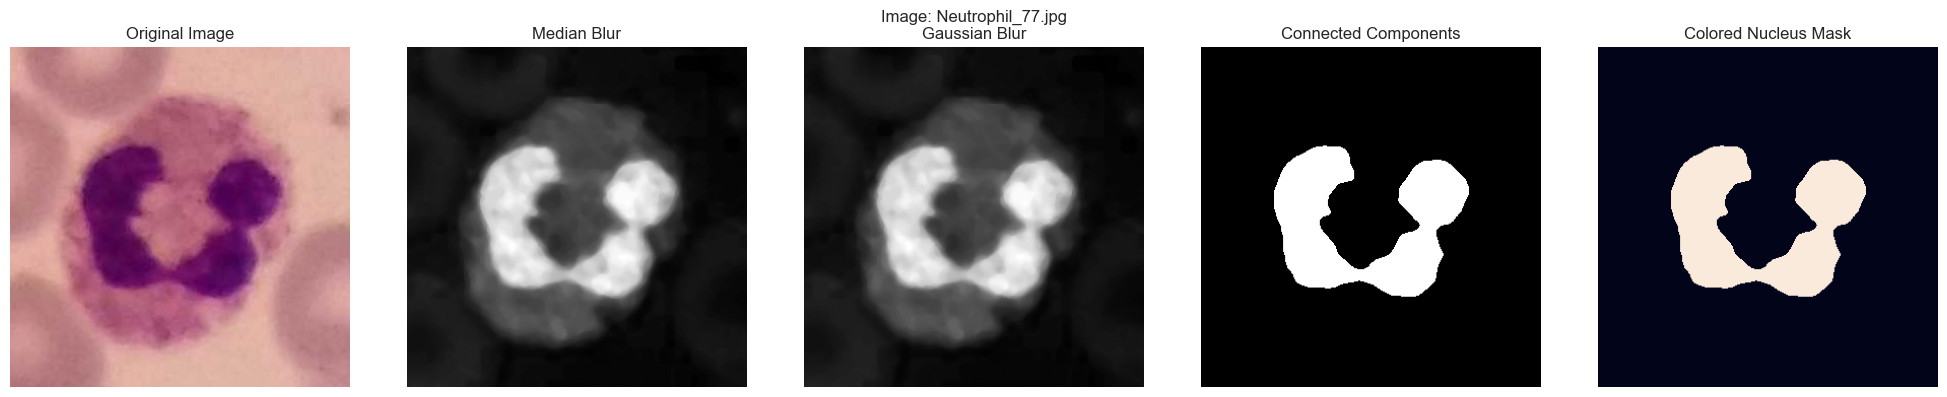

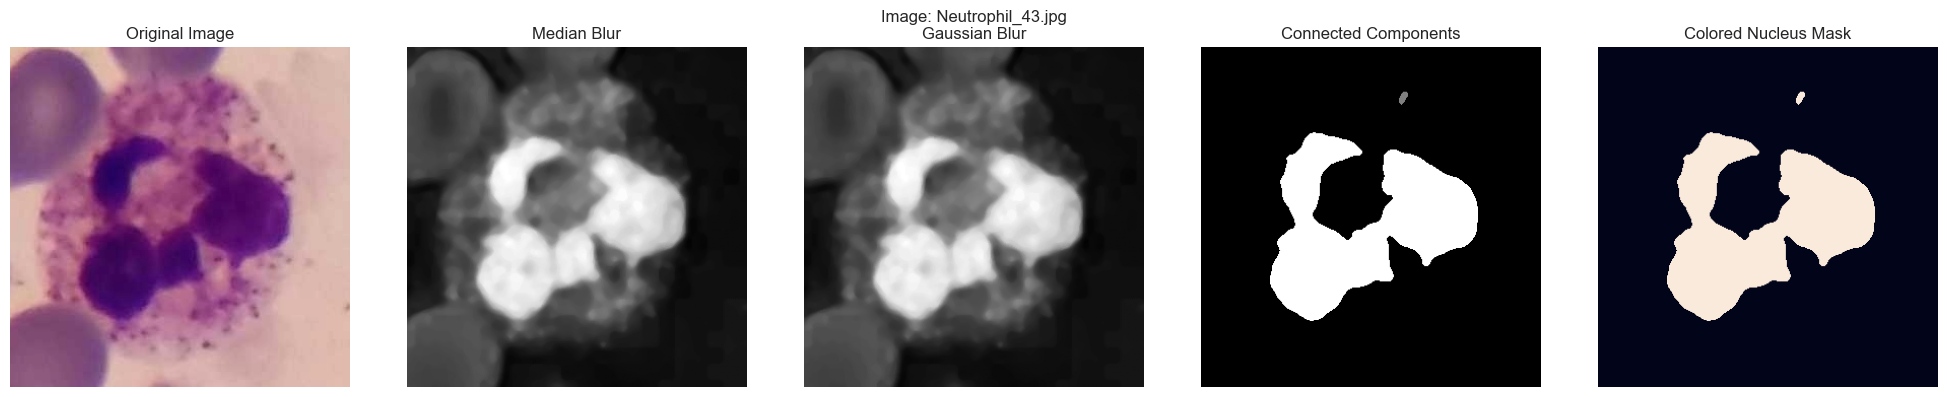

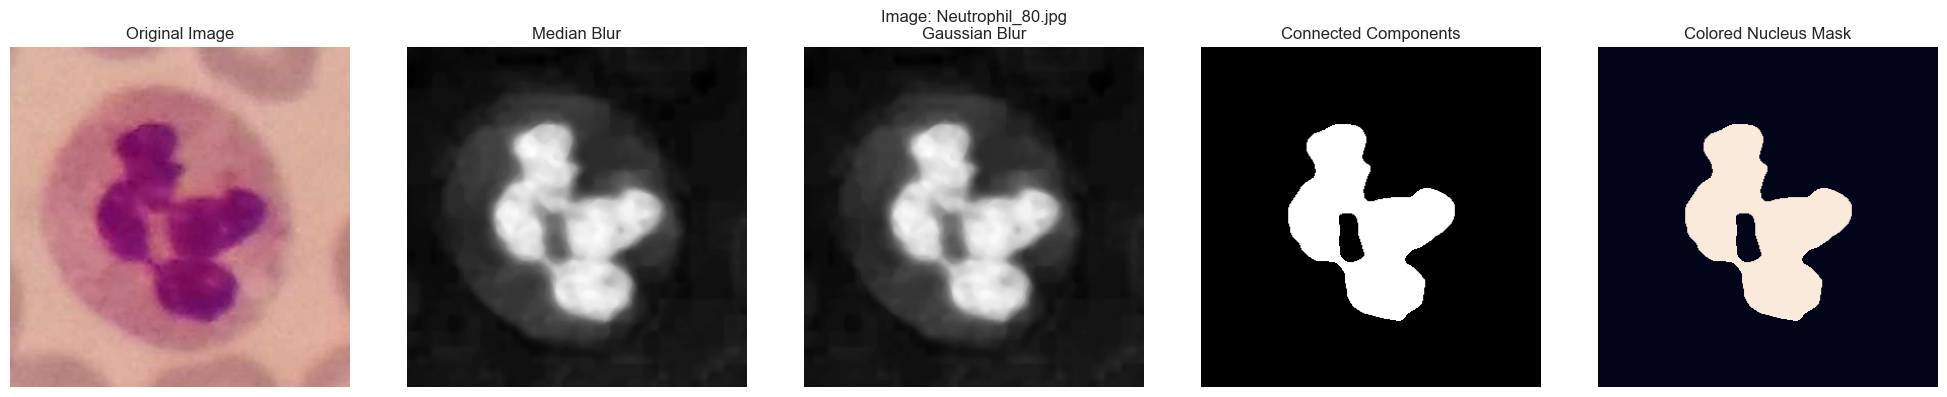

In [89]:

# Folder path
image_dir = r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Neutrophil"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random_images = random.sample(image_files, 10)

# Loop through each image
# Loop through each image
for idx, file in enumerate(random_images):
    image_path = os.path.join(image_dir, file)
    img = image_read_hsv(image_path)

    if img is None:
        continue

    h, s, v = cv2.split(img)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)  # Convert back to BGR for original display
    img_blur = cv2.medianBlur(s, 7)
    img_gauss = apply_gauss(img_blur, 3, 0.2)
    nuc_img, eq_list = connectivit_8(img_gauss, 255, 140)
    final_img = color_img(nuc_img, 255)

    # Plotting
    plt.figure(figsize=(20, 4))
    plt.suptitle(f"Image: {file}", fontsize=12)

    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(img_blur, cmap='gray')
    plt.title('Median Blur')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(img_gauss, cmap='gray')
    plt.title('Gaussian Blur')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(nuc_img, cmap='gray')
    plt.title('Connected Components')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(final_img)
    plt.title('Colored Nucleus Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


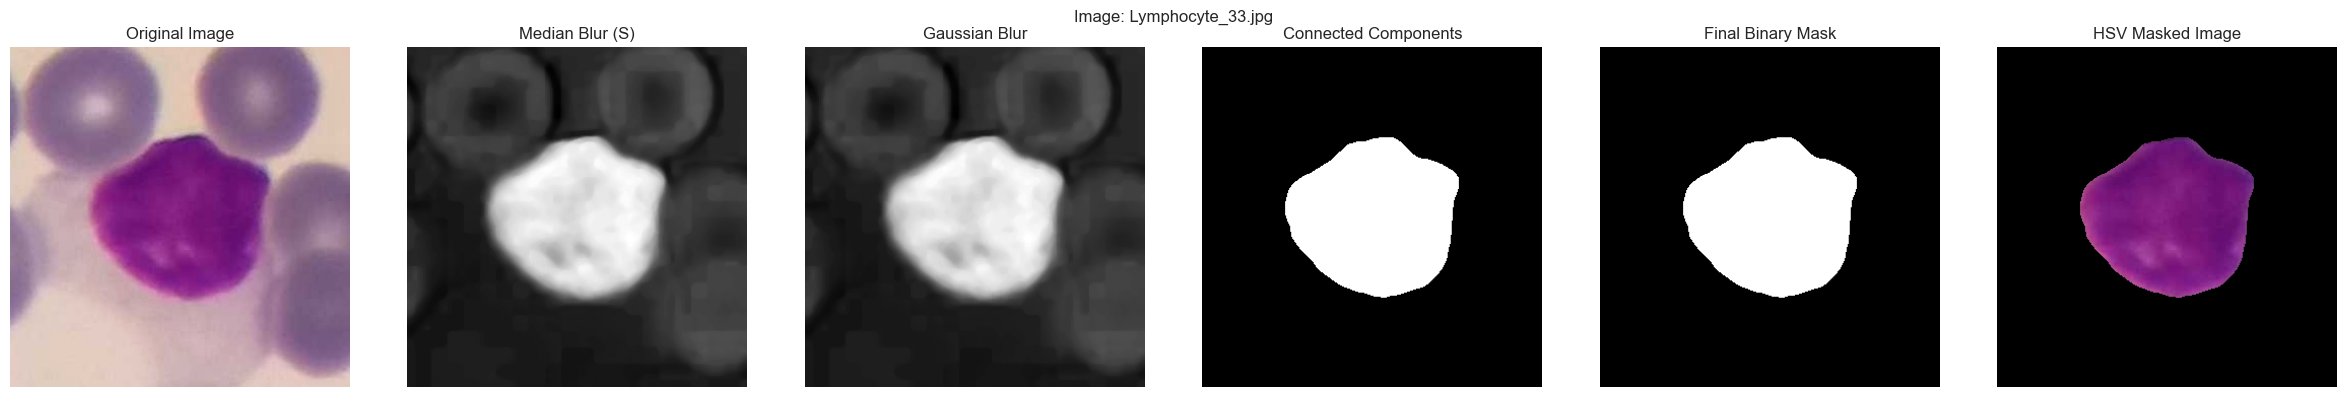

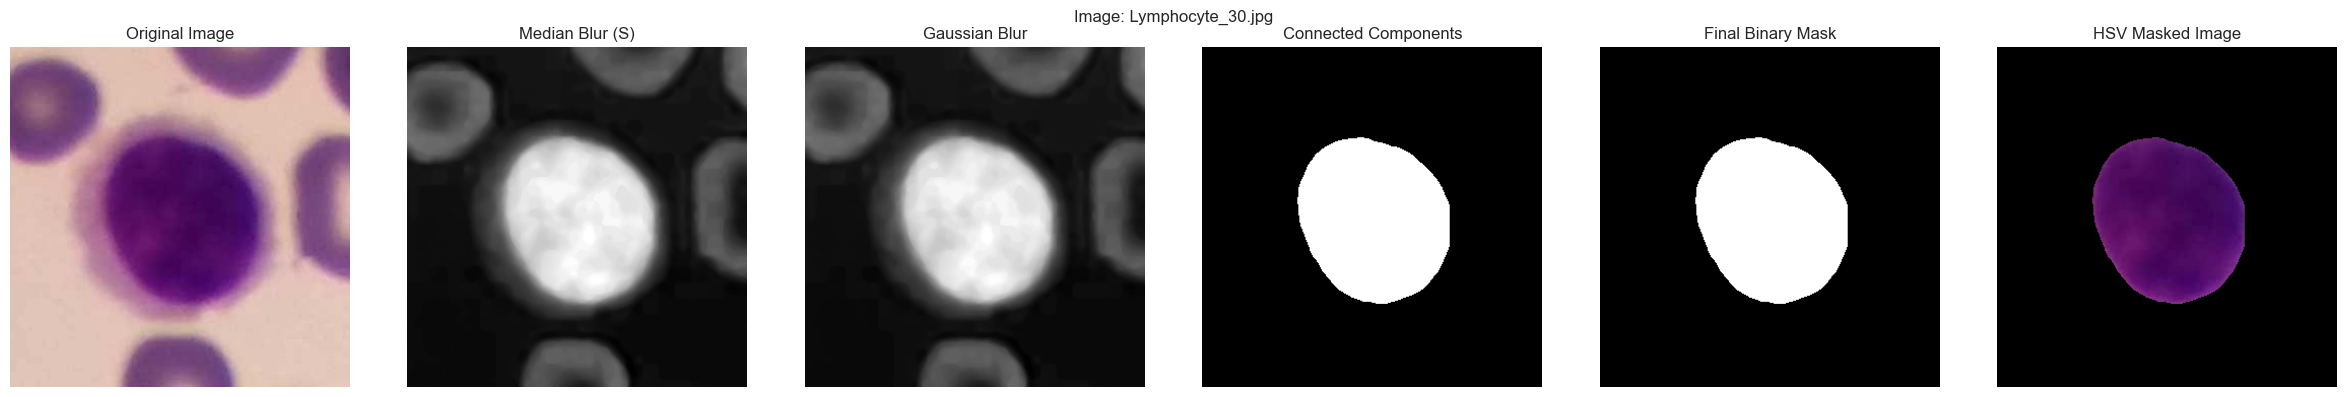

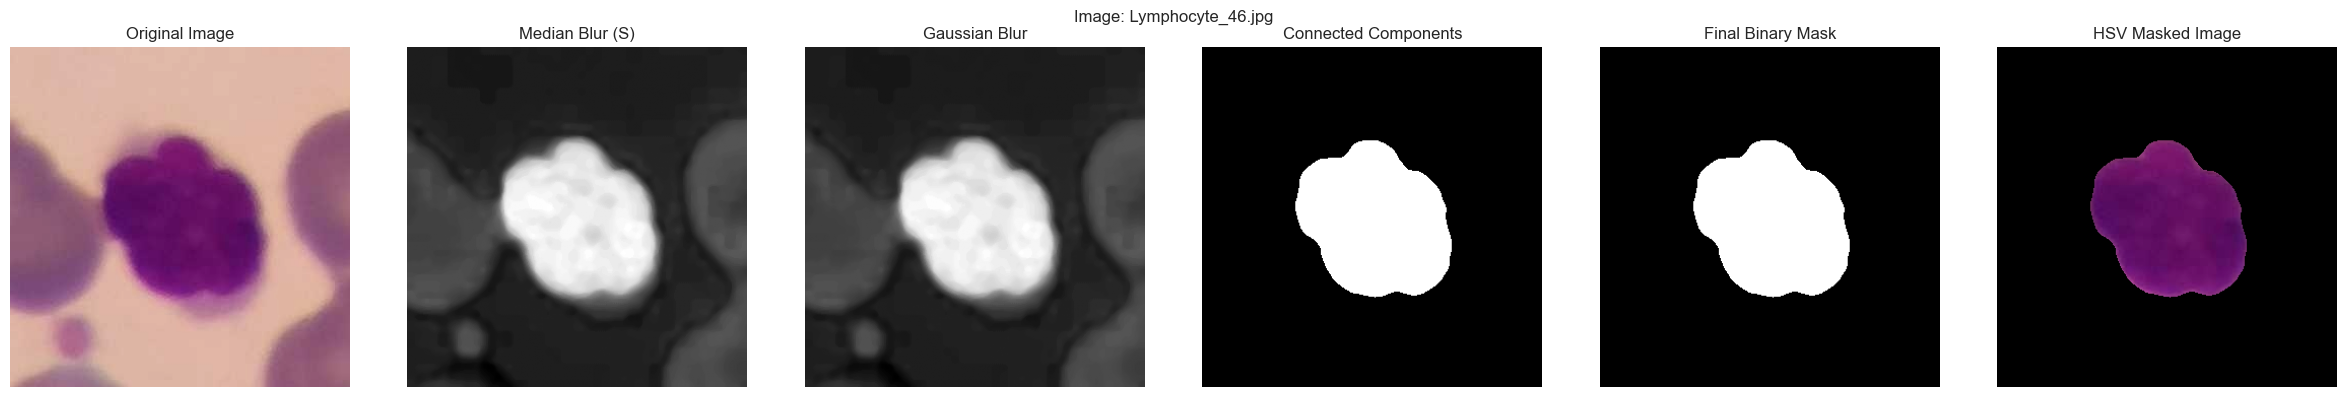

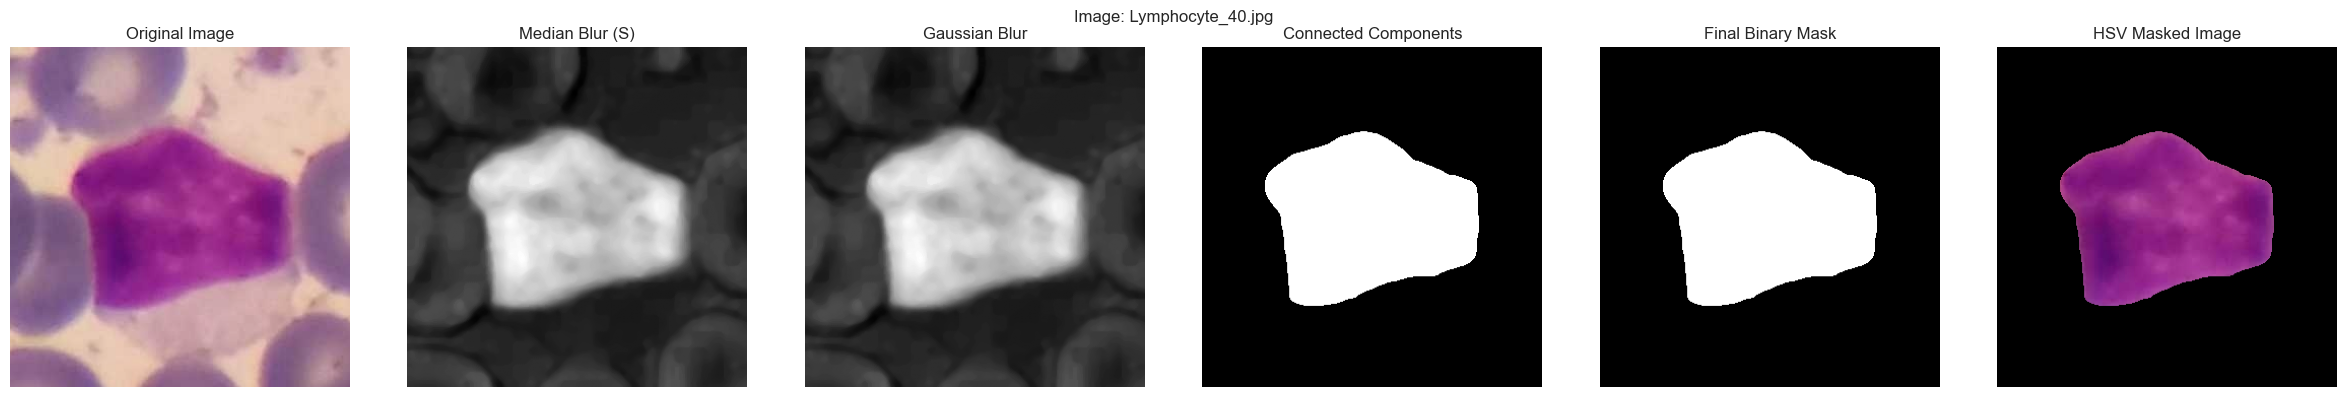

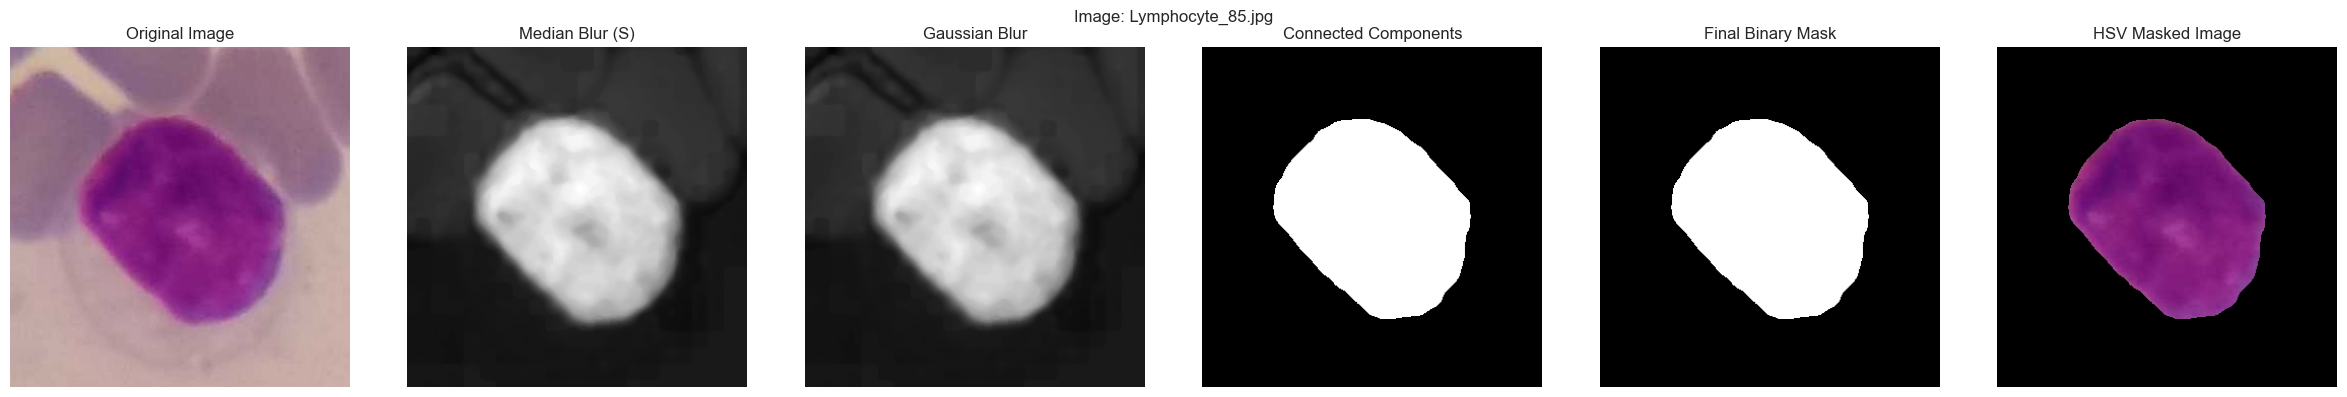

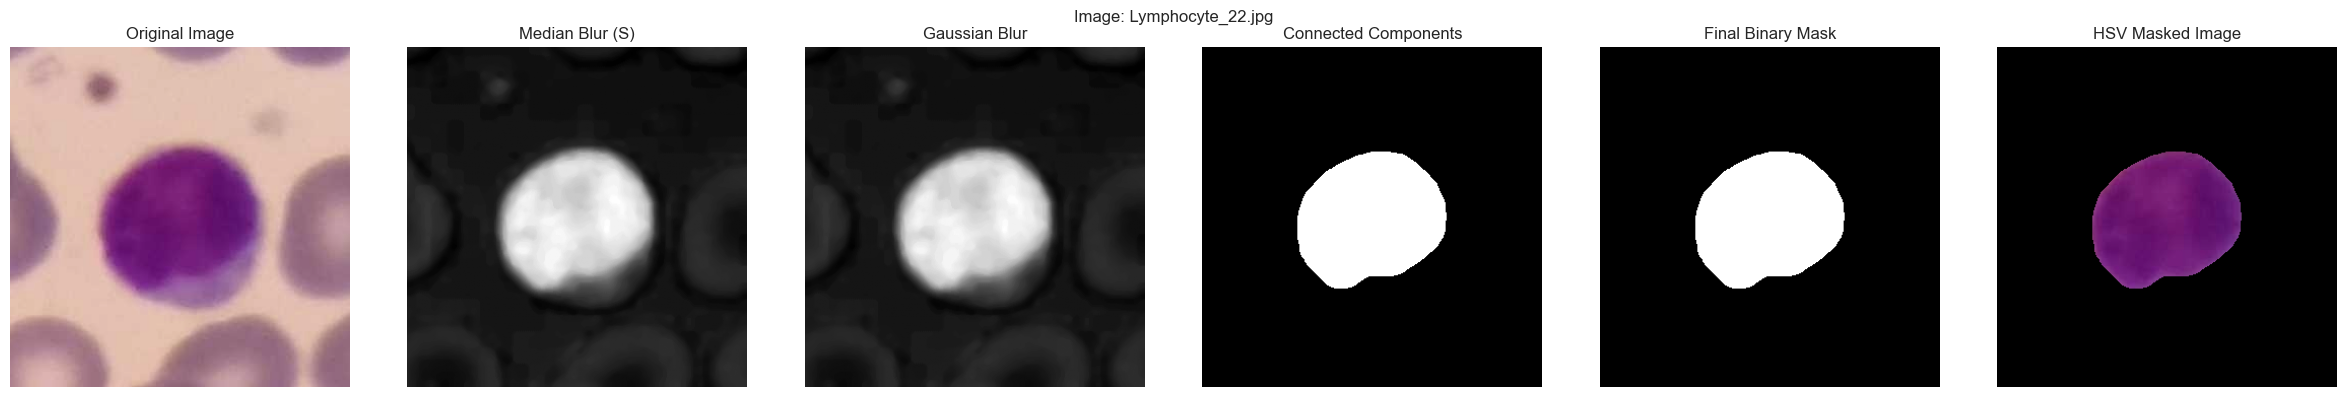

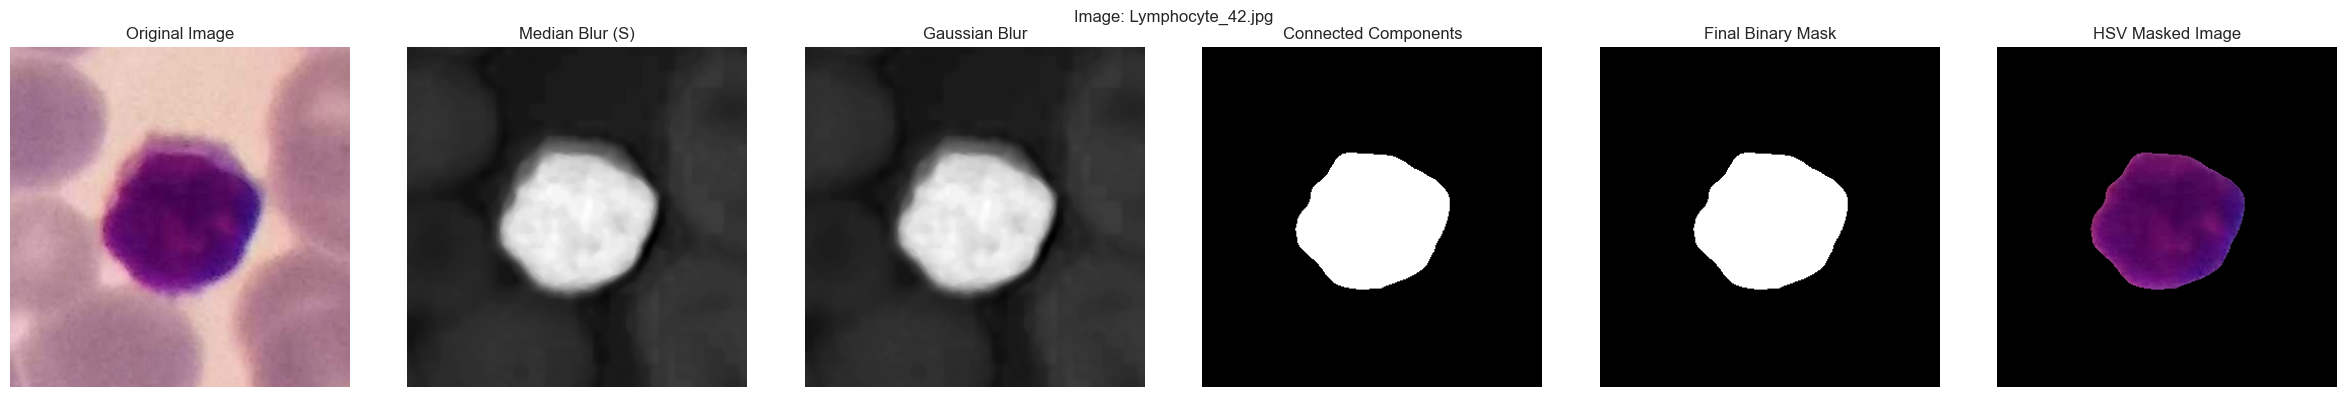

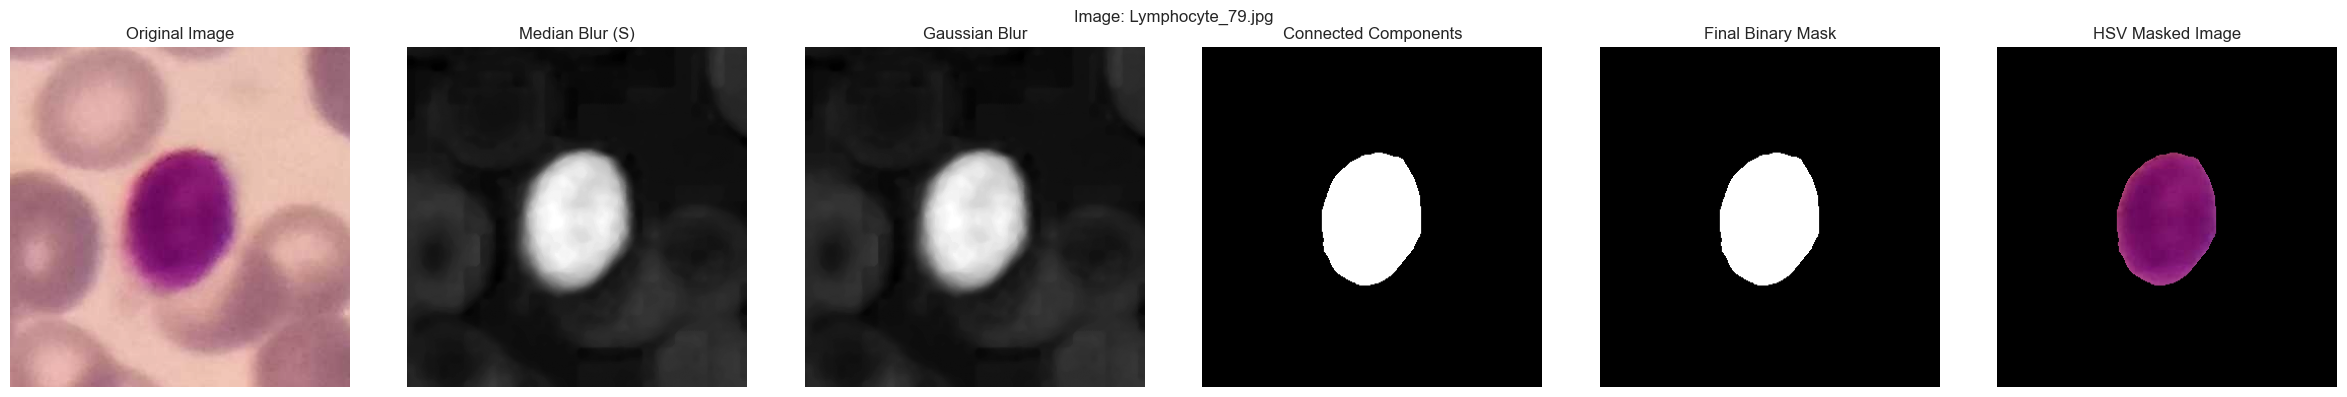

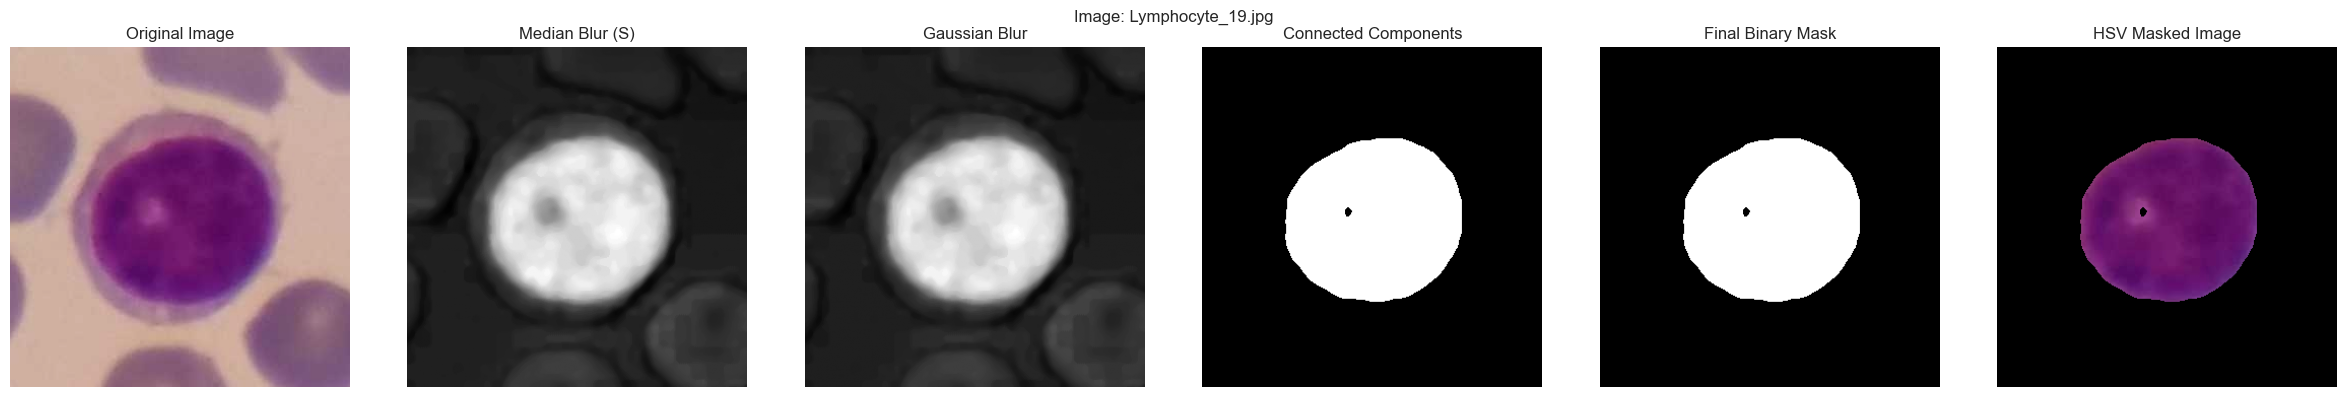

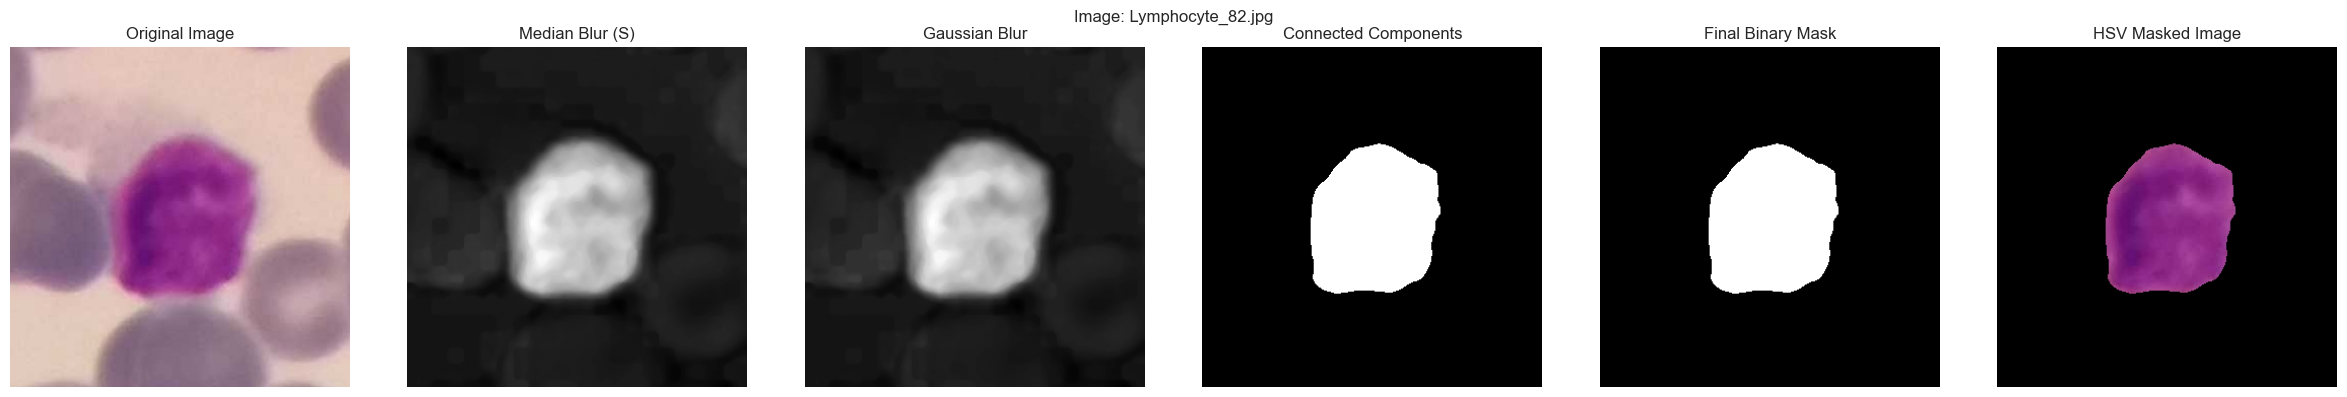

In [2]:
import os
import random

# Folder path
image_dir = r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Lymphocyte"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random_images = random.sample(image_files, 10)

for idx, file in enumerate(random_images):
    image_path = os.path.join(image_dir, file)
    img_hsv = image_read_hsv(image_path)

    if img_hsv is None:
        continue

    h, s, v = cv2.split(img_hsv)

    img_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)  # Original BGR image
    img_blur = cv2.medianBlur(s, 7)
    img_gauss = apply_gauss(img_blur, 3, 0.2)
    nuc_img, eq_list = connectivit_8(img_gauss, 255, 140)
    final_mask = color_img(nuc_img, 255)

    # Mask HSV image using nucleus mask (on Saturation)
    hsv_masked = cv2.bitwise_and(img_hsv, img_hsv, mask=final_mask)
    masked_bgr = cv2.cvtColor(hsv_masked, cv2.COLOR_HSV2RGB)  # Convert to RGB for display

    # Plotting
    plt.figure(figsize=(24, 4))
    plt.suptitle(f"Image: {file}", fontsize=12)

    plt.subplot(1, 6, 1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(img_blur, cmap='gray')
    plt.title('Median Blur (S)')
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(img_gauss, cmap='gray')
    plt.title('Gaussian Blur')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(nuc_img, cmap='gray')
    plt.title('Connected Components')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Final Binary Mask')
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(masked_bgr)
    plt.title('HSV Masked Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


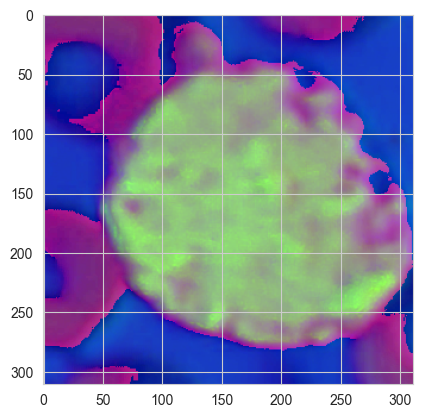

In [78]:
image_path = r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Basophil\Basophil_1.jpg"
img = image_read_hsv(image_path)

plt.imshow(img)


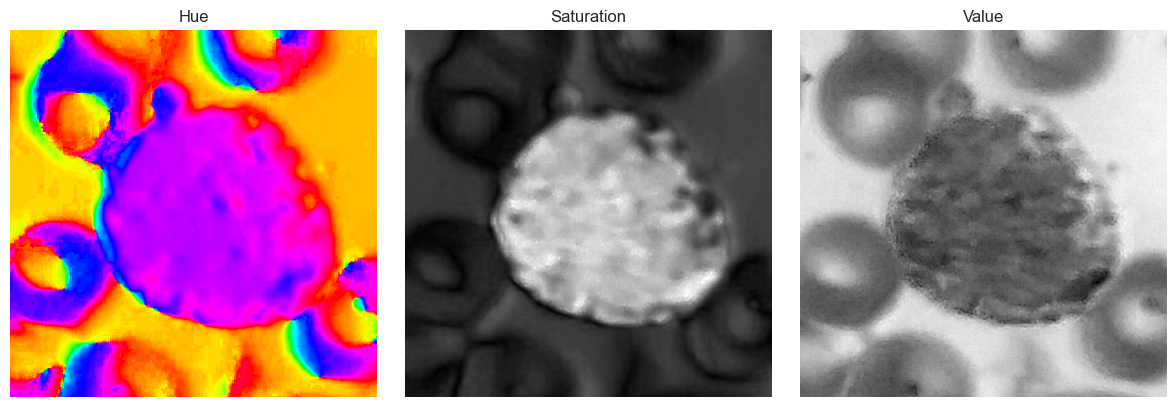

In [60]:
h, s, v = cv2.split(img)

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(h, cmap='hsv')
plt.title('Hue')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(s, cmap='gray')
plt.title('Saturation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(v, cmap='gray')
plt.title('Value')
plt.axis('off')

plt.tight_layout()
plt.show()


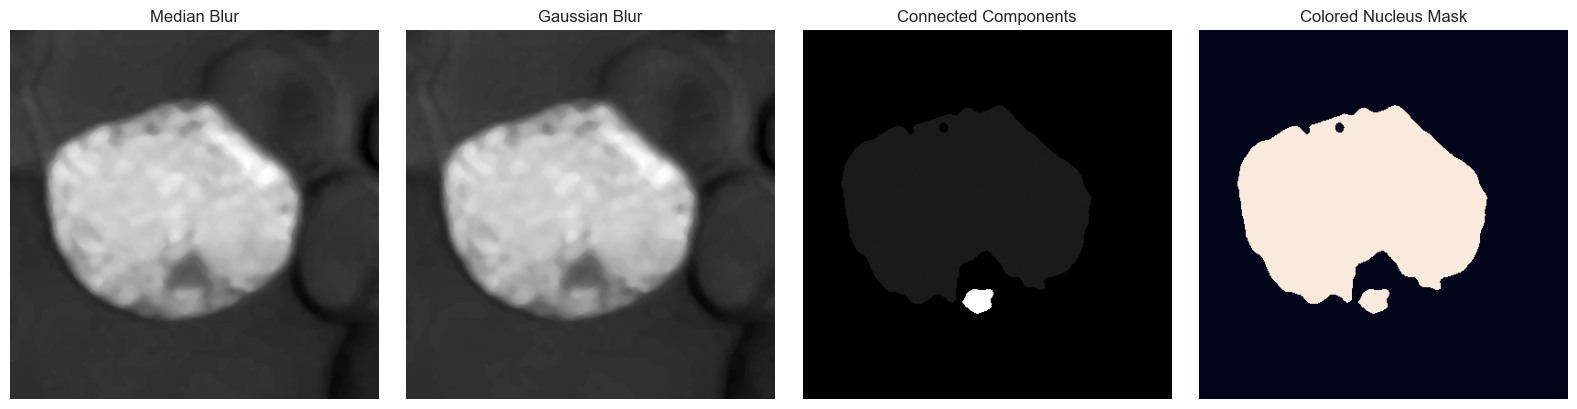

In [64]:
image_path = r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Basophil\Basophil_2.jpg"
img = image_read_hsv(image_path)

h, s, v = cv2.split(img)

img = cv2.medianBlur(s, 7)
img1 = apply_gauss(img, 3, 0.2)
nuc_img, eq_list = connectivit_8(img1, 255, 140)
final_img = color_img(nuc_img, 255)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Median Blur')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img1, cmap='gray')
plt.title('Gaussian Blur')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(nuc_img, cmap='gray')
plt.title('Connected Components')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(final_img)
plt.title('Colored Nucleus Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


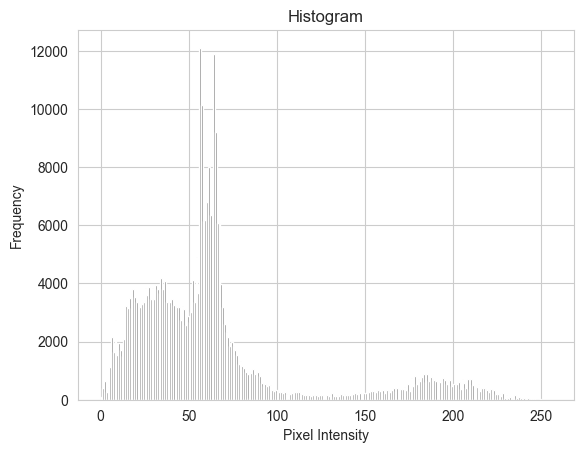

In [17]:
plt.hist(img1.ravel(), bins=256, range=(0, 256), color='gray')
plt.title("Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


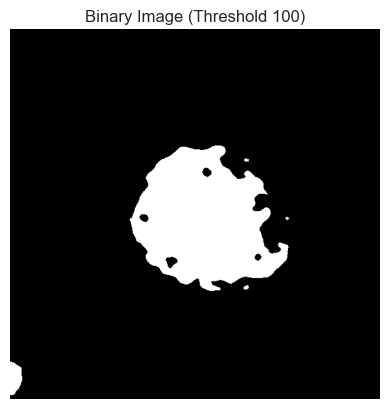

In [19]:
binary_img = np.where(img1 > 150, 255, 0).astype(np.uint8)

plt.imshow(binary_img, cmap='gray')
plt.title("Binary Image (Threshold 100)")
plt.axis('off')
plt.show()
